# Model XYZ
 Using aggregated invoice data

Summary here...

In [1]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

## Run data cleaning script, generate parquet files. 
Requires pyarrow and fastparquet (see requirements.txt)

In [2]:
# Open and run **ETL_export_parquet_invoice-level_+_client-level_mean.py**

## Import parquet files

In [2]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarised. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [4]:
# Choose dataset to use in this document
df = df_train_agg
df_final_test = df_final_test_agg

In [5]:
df.head()

,creation_date,target,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC,...,counter_code_450,counter_code_453,counter_code_467,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65
0,34699,0,35,1.0,352.400000,10.571429,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
1,37405,0,37,1.0,557.540541,0.000000,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
2,31484,0,18,1.0,798.611111,37.888889,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
3,35257,0,20,1.0,1.200000,0.000000,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
4,41926,0,14,1.0,663.714286,104.857143,117.357143,36.714286,False,True,...,False,False,False,False,False,False,False,False,False,False


In [6]:
df.describe()

,creation_date,target,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,reading_remarque,counter_statue
count,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000
mean,37801.779602,0.059078,34.615531,1.001211,407.277247,117.619880,27.496823,75.918575,8.781734,0.010695
std,4107.568660,0.235772,25.782890,0.183005,342.787037,756.054243,96.626119,833.338704,0.726306,0.160331
min,28161.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,34858.000000,0.000000,13.000000,1.000000,220.530312,0.000000,0.000000,0.000000,9.000000,0.000000
50%,39018.500000,0.000000,31.500000,1.000000,355.161002,6.892857,0.000000,0.000000,9.000000,0.000000
75%,41108.000000,0.000000,52.000000,1.000000,533.078947,66.688702,5.560244,0.000000,9.000000,0.000000
max,43718.000000,1.000000,434.000000,40.000000,34024.000000,115683.000000,2400.000000,79179.777778,9.000000,5.000000


## Split Data to Train and Test

In [5]:
# Make sure final_test has same dummy columns in as training data (filled with False)
def add_missing_dummy_columns_and_fill_false(train, final_test): 

    cols_missing_from_final_test = (set(train) - set(final_test)) - set(['target'])

    for cols in cols_missing_from_final_test:   
        final_test[cols] = False
    print(f"Adding new cols to final_test: {cols_missing_from_final_test}")

add_missing_dummy_columns_and_fill_false(df, df_final_test)

Adding new cols to final_test: {'region_199', 'counter_code_305', 'counter_code_307'}


In [6]:
X = df.loc[:, ~df.columns.isin(["target"])]
y = df["target"]
X_final_test = df_final_test

# make sure column order the same in X and X_final_test
X, X_final_test = X.align(X_final_test, join="right", axis=1)

RSEED = 42

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RSEED
)


## Imputing missing values

In [7]:
# % of missing values for each column in Training data
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

creation_date       0.0
tarif_type_11       0.0
counter_code_214    0.0
counter_code_210    0.0
counter_code_207    0.0
                   ... 
region_302          0.0
region_301          0.0
region_206          0.0
region_199          0.0
counter_code_65     0.0
Length: 89, dtype: float64

In [8]:
# % of missing values for each column in the final test data. Compare with training data above to see if similar proportion.
(100 * df_final_test.isnull().sum() / df_final_test.count()).sort_values(ascending=False)

creation_date         0.0
transactions_count    0.0
counter_code_222      0.0
counter_code_214      0.0
counter_code_210      0.0
                     ... 
region_303            0.0
region_302            0.0
region_301            0.0
region_206            0.0
counter_code_307      0.0
Length: 88, dtype: float64

In [9]:
# What does the data look like for rows with missing data
df_missing_values = df[pd.isnull(df["transactions_count"]) == True]

In [10]:
X_train

,creation_date,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC,reading_remarque,...,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65,region_199,counter_code_305,counter_code_307
75397,38240,22,1.0,403.363636,0.00,0.0,0.0,True,True,9,...,False,False,False,False,False,False,False,False,False,False
42169,36136,26,1.0,964.730769,0.00,0.0,0.0,True,True,9,...,False,False,False,False,False,False,False,False,False,False
26133,28458,30,1.0,2598.300000,91.00,0.0,0.0,False,True,8,...,False,False,False,False,False,False,False,False,False,False
21406,40522,4,1.0,1339.750000,174.50,0.0,0.0,False,True,8,...,False,False,False,False,False,False,False,False,False,False
79746,39233,63,1.0,159.301587,0.00,0.0,0.0,True,True,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31328,39317,60,1.0,328.500000,6.75,0.0,0.0,True,True,9,...,False,False,False,False,False,False,False,False,False,False
98598,36669,37,1.0,278.972973,0.00,0.0,0.0,False,True,9,...,False,False,False,False,False,False,False,False,False,False
21720,35794,26,1.0,334.500000,0.00,0.0,0.0,False,True,9,...,False,False,False,False,False,False,False,False,False,False
27505,35691,47,1.0,287.170213,0.00,0.0,0.0,True,True,9,...,False,False,False,False,False,False,False,False,False,False


In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

In [13]:
# Pipeline

cat_features = list(X_train.columns[X_train_resampled.dtypes==object])
num_features = list(X_train.columns[X_train_resampled.dtypes!=object])

from sklearn.pipeline import Pipeline

# Pipeline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')), # replace 0s with means 
   # ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTransformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Train Model

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Create a pipeline with preprocessing and LogisticRegression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))  # Logistic Regression
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'logreg__penalty': ['l1', 'l2'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__class_weight': [None, 'balanced']  # Class weighting
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print progress
)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_train_predict = best_model.predict(X_train_resampled)
y_test_predict = best_model.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'logreg__C': 1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1'}
Best F1 Score: 0.6688351027531335


## Metrics for Best Model

Accuracy: 0.66
Precision: 0.65
Recall: 0.69
F1 Score: 0.67


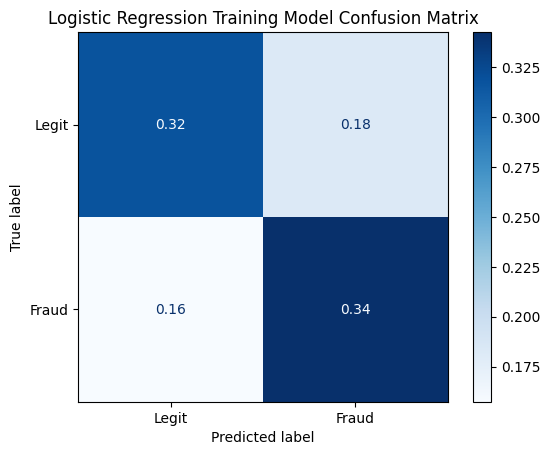

In [15]:
# Calculate metrics
accuracy = accuracy_score(y_train_resampled, y_train_predict)
precision = precision_score(y_train_resampled, y_train_predict)
recall = recall_score(y_train_resampled, y_train_predict)
f1 = f1_score(y_train_resampled, y_train_predict)


# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Generate the confusion matrix
cm = confusion_matrix(y_train_resampled, y_train_predict, normalize='all')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Logistic Regression Training Model Confusion Matrix')
plt.show()

Accuracy: 0.64
Precision: 0.10
Recall: 0.67
F1 Score: 0.18


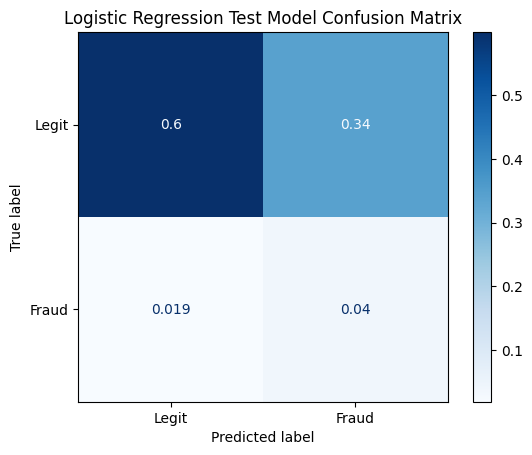

In [16]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict)
recall = recall_score(y_test, y_test_predict)
f1 = f1_score(y_test, y_test_predict)


# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_predict, normalize='all')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Logistic Regression Test Model Confusion Matrix')
plt.show()

# Save best model for future use

In [22]:
# https://scikit-learn.org/stable/model_persistence.html#skops-persistence

timestamp_for_filename = time.strftime("%Y-%m %d_%H%M%S")
model_name = "example_model"

filepath = f"./models/{model_name} {timestamp_for_filename}.skops"

obj = dump(best_model, filepath)
